# Data Science Praktikum 3

## 1. Datenvorbereitung

### 1.1 Bibliotheken importieren

In [253]:
# Grundlegende Bibliotheken
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Für bessere Visualisierungen
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

### 1.2 Daten laden

In [254]:
# Datei-URL (lokal gespeichert)
file_path = 'heart_disease_uci.csv'

try:
	# Laden des Datasets
	data = pd.read_csv(file_path)
	print(f"Dataset erfolgreich geladen. Anzahl der Einträge: {data.shape[0]}, Anzahl der Merkmale: {data.shape[1]}")
except FileNotFoundError:
	print("Die Datei wurde nicht gefunden. Bitte stelle sicher, dass die Datei im richtigen Pfad liegt.")

Dataset erfolgreich geladen. Anzahl der Einträge: 920, Anzahl der Merkmale: 16


### 1.3 Datenexploration

In [255]:
# Anzeigen der ersten Zeilen
print("Erste 5 Zeilen des Datasets:")
print(data.head())

# Informationen über das Dataset
print("\nInformationen über das Dataset:")
data.info()

# Statistische Beschreibung
print("\nStatistische Beschreibung:")
print(data.describe())

# Überprüfen, ob bereits fehlende Werte im originalen Dataset vorhanden sind
missing_values = data.isnull().sum()
total_missing = missing_values.sum()
print(f"\nAnzahl der fehlenden Werte im originalen Dataset: {total_missing}")
if total_missing > 0:
	print("Spalten mit fehlenden Werten:")
	print(missing_values[missing_values > 0])
else:
	print("Das originale Dataset enthält keine fehlenden Werte. Für diese Aufgabe werden wir künstlich fehlende Werte erzeugen.")

Erste 5 Zeilen des Datasets:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4      

### 1.4 Vorbereitung der Werte und Spalten

In [256]:
# Überprüfen der eindeutigen Werte in der Zielvariable (heißt 'num' in deinem Dataset)
print("Eindeutige Werte in der Zielvariable 'num':")
print(data['num'].unique())

# Verteilung anzeigen
print("Verteilung der Werte in 'num':")
print(data['num'].value_counts().sort_index())

# Reduzieren auf binäre Klassifikation (0: keine Herzkrankheit, 1-4: mit Herzkrankheit)
if len(data['num'].unique()) > 2:
	# Original-Werte sichern für Mapping-Info
	original_values = data['num'].copy()

	# Konvertierung: 0 bleibt 0, alle anderen Werte (1,2,3,4) werden zu 1
	data['num'] = data['num'].apply(lambda x: 0 if x == 0 else 1)

	print("Zielvariable 'num' auf binäre Klassifikation reduziert.")
	print("Mapping:")
	for orig_val in sorted(original_values.unique()):
		new_val = 0 if orig_val == 0 else 1
		count = (original_values == orig_val).sum()
		print(f"  {orig_val} -> {new_val} ({count} Fälle)")

	print("Neue eindeutige Werte in 'num':")
	print(data['num'].unique())
else:
	print("Die Zielvariable ist bereits binär.")

# Zu 'target' umbenennen für Konsistenz mit dem restlichen Code
data = data.rename(columns={'num': 'target'})
print("Spalte 'num' wurde zu 'target' umbenannt für Konsistenz.")

# Finaler Check
print(f"\nFinale Zielvariable 'target':")
print(f"Eindeutige Werte: {sorted(data['target'].unique())}")
print(f"Verteilung:")
print(data['target'].value_counts().sort_index())

Eindeutige Werte in der Zielvariable 'num':
[0 2 1 3 4]
Verteilung der Werte in 'num':
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64
Zielvariable 'num' auf binäre Klassifikation reduziert.
Mapping:
  0 -> 0 (411 Fälle)
  1 -> 1 (265 Fälle)
  2 -> 1 (109 Fälle)
  3 -> 1 (107 Fälle)
  4 -> 1 (28 Fälle)
Neue eindeutige Werte in 'num':
[0 1]
Spalte 'num' wurde zu 'target' umbenannt für Konsistenz.

Finale Zielvariable 'target':
Eindeutige Werte: [np.int64(0), np.int64(1)]
Verteilung:
target
0    411
1    509
Name: count, dtype: int64


### 1.5 Kodierung kategorialer Variablen

In [257]:
# Identifizierung kategorialer Variablen
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Kategoriale Variablen: {categorical_cols}")

# Kodierung kategorialer Variablen
for col in categorical_cols:
	le = LabelEncoder()
	data[col] = le.fit_transform(data[col])
	print(f"Variable '{col}' wurde kodiert: {le.classes_} -> {list(range(len(le.classes_)))}")

# Anzeigen der kodierten Daten
print("\nKodierte Daten:")
print(data.head())

Kategoriale Variablen: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Variable 'sex' wurde kodiert: ['Female' 'Male'] -> [0, 1]
Variable 'dataset' wurde kodiert: ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach'] -> [0, 1, 2, 3]
Variable 'cp' wurde kodiert: ['asymptomatic' 'atypical angina' 'non-anginal' 'typical angina'] -> [0, 1, 2, 3]
Variable 'fbs' wurde kodiert: [False True nan] -> [0, 1, 2]
Variable 'restecg' wurde kodiert: ['lv hypertrophy' 'normal' 'st-t abnormality' nan] -> [0, 1, 2, 3]
Variable 'exang' wurde kodiert: [False True nan] -> [0, 1, 2]
Variable 'slope' wurde kodiert: ['downsloping' 'flat' 'upsloping' nan] -> [0, 1, 2, 3]
Variable 'thal' wurde kodiert: ['fixed defect' 'normal' 'reversable defect' nan] -> [0, 1, 2, 3]

Kodierte Daten:
   id  age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
0   1   63    1        0   3     145.0  233.0    1        0   150.0      0   
1   2   67    1        0   0     160.0  286.0    0     

### 1.6 Ersetzen von fehlenden Werten durch NaN

In [258]:
# Originaldaten sichern
original_data = data.copy()

# Funktion zur Einführung fehlender Werte
def introduce_missing_values(df, percent_missing=0.1, exclude_cols=None):
	"""
    Führt zufällig fehlende Werte in einem DataFrame ein.

    Parameters:
    df (pandas.DataFrame): Der DataFrame, in dem fehlende Werte eingeführt werden sollen.
    percent_missing (float): Prozentsatz der fehlenden Werte pro Spalte (zwischen 0 und 1).
    exclude_cols (list): Liste von Spaltennamen, die keine fehlenden Werte haben sollen.

    Returns:
    pandas.DataFrame: DataFrame mit eingeführten fehlenden Werten.
    """
	if exclude_cols is None:
		exclude_cols = []

	df_missing = df.copy()

	# Für jede Spalte, die nicht ausgeschlossen ist
	for column in df.columns:
		if column not in exclude_cols:
			# Anzahl der einzuführenden fehlenden Werte
			n_missing = int(df.shape[0] * percent_missing)

			# Zufällige Indizes auswählen
			missing_indices = np.random.choice(df.shape[0], n_missing, replace=False)

			# NaN-Werte einsetzen
			df_missing.loc[missing_indices, column] = np.nan

	return df_missing

# Einführung fehlender Werte (außer in der Zielspalte)
data_with_missing = introduce_missing_values(data, percent_missing=0.15, exclude_cols=['target'])

# Überprüfen der eingeführten fehlenden Werte
missing_values = data_with_missing.isnull().sum()
missing_percentage = (missing_values / len(data_with_missing)) * 100
missing_info = pd.DataFrame({
	'Fehlende Werte': missing_values,
	'Prozentsatz': missing_percentage
})
print("Eingeführte fehlende Werte:")
print(missing_info[missing_info['Fehlende Werte'] > 0].sort_values('Fehlende Werte', ascending=False))

Eingeführte fehlende Werte:
          Fehlende Werte  Prozentsatz
ca                   660    71.739130
oldpeak              193    20.978261
trestbps             186    20.217391
thalch               183    19.891304
chol                 164    17.826087
sex                  138    15.000000
id                   138    15.000000
dataset              138    15.000000
cp                   138    15.000000
age                  138    15.000000
fbs                  138    15.000000
exang                138    15.000000
restecg              138    15.000000
slope                138    15.000000
thal                 138    15.000000


### 1.7 Visualisierung der Daten

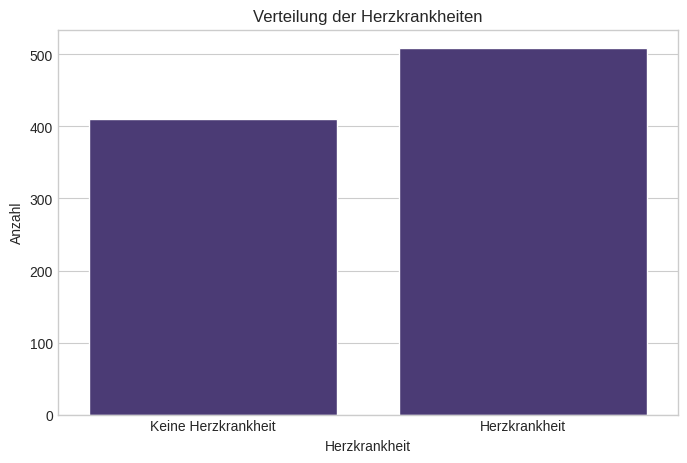

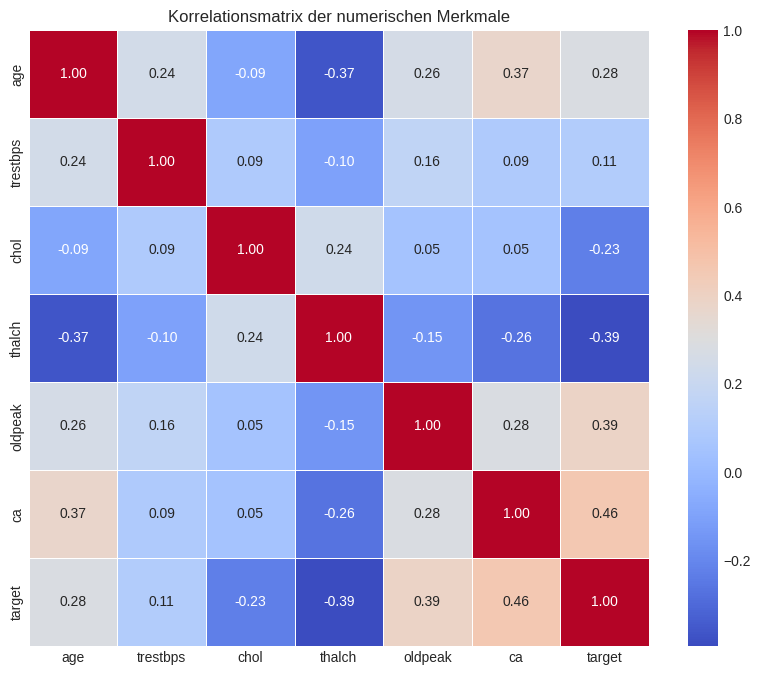

<Figure size 1200x1000 with 0 Axes>

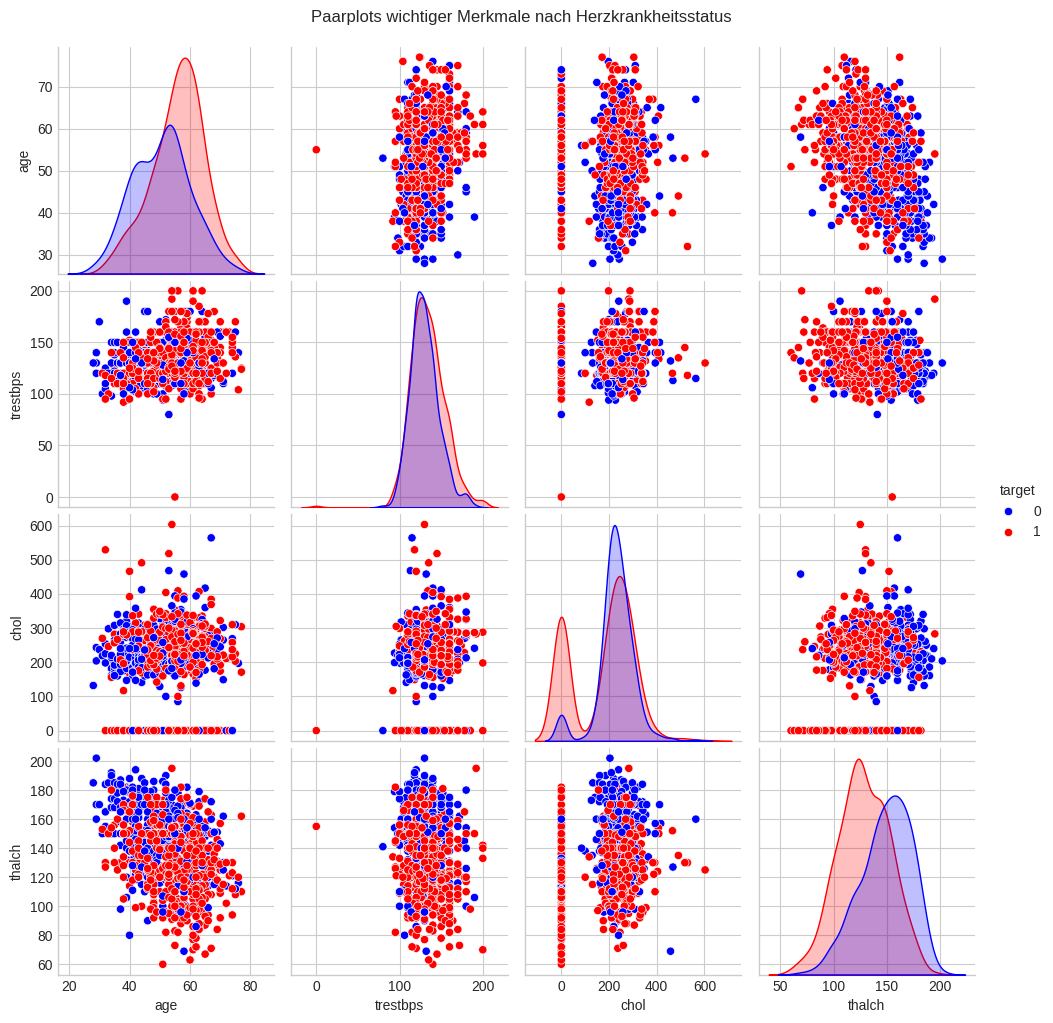

In [259]:
# 1.7 Visualisierung der Daten - Komplett korrigiert

# Zielvariable visualisieren
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=data_with_missing)
plt.title('Verteilung der Herzkrankheiten')
plt.xlabel('Herzkrankheit')
plt.ylabel('Anzahl')
plt.xticks([0, 1], ['Keine Herzkrankheit', 'Herzkrankheit'])
plt.show()

# Korrelationsmatrix (nur numerische Variablen, ohne id)
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'target']
plt.figure(figsize=(10, 8))
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korrelationsmatrix der numerischen Merkmale')
plt.show()

# Paarplots für wichtige Merkmale
important_features = ['age', 'trestbps', 'chol', 'thalch', 'target']
plt.figure(figsize=(12, 10))
sns.pairplot(data[important_features], hue='target', palette=['blue', 'red'])
plt.suptitle('Paarplots wichtiger Merkmale nach Herzkrankheitsstatus', y=1.02)
plt.show()

### 1.8 Aufteilen in Trainings- und Testsets

In [260]:
# Features und Zielvariable definieren
X = data_with_missing.drop('target', axis=1)
y = data_with_missing['target']

# Aufteilen in Trainings- und Testsets (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Trainingsdaten: {X_train.shape[0]} Einträge")
print(f"Testdaten: {X_test.shape[0]} Einträge")

Trainingsdaten: 736 Einträge
Testdaten: 184 Einträge


## 2. Analyse fehlender Werte

### 2.1 Untersuchung des Ausmaßes und der Art der fehlenden Werte

Fehlende Werte im Trainingsdatensatz:
          Fehlende Werte  Prozentsatz
ca                   524    71.195652
oldpeak              156    21.195652
trestbps             151    20.516304
thalch               151    20.516304
chol                 138    18.750000
id                   119    16.168478
sex                  117    15.896739
cp                   112    15.217391
fbs                  112    15.217391
exang                109    14.809783
dataset              108    14.673913
slope                108    14.673913
thal                 106    14.402174
restecg              104    14.130435
age                  100    13.586957


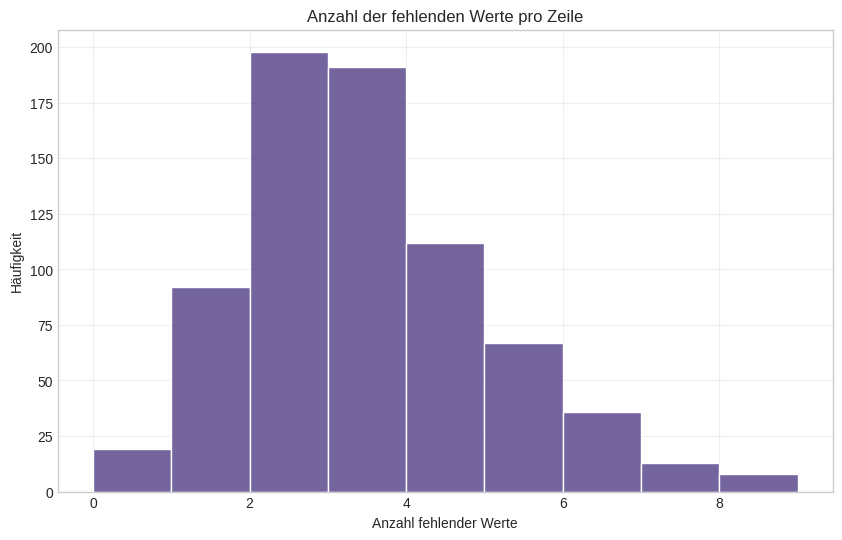

In [261]:
# Anzahl und Prozentsatz fehlender Werte in jeder Spalte
missing_values = X_train.isnull().sum()
missing_percentage = (missing_values / len(X_train)) * 100
missing_info = pd.DataFrame({
	'Fehlende Werte': missing_values,
	'Prozentsatz': missing_percentage
})
print("Fehlende Werte im Trainingsdatensatz:")
print(missing_info[missing_info['Fehlende Werte'] > 0].sort_values('Fehlende Werte', ascending=False))

# Verteilung der fehlenden Werte pro Zeile
plt.figure(figsize=(10, 6))
missing_per_row = X_train.isnull().sum(axis=1)
sns.histplot(missing_per_row, bins=range(0, max(missing_per_row)+2))
plt.title('Anzahl der fehlenden Werte pro Zeile')
plt.xlabel('Anzahl fehlender Werte')
plt.ylabel('Häufigkeit')
plt.grid(True, alpha=0.3)
plt.show()

### 2.2 Visualisierung der Muster fehlender Werte

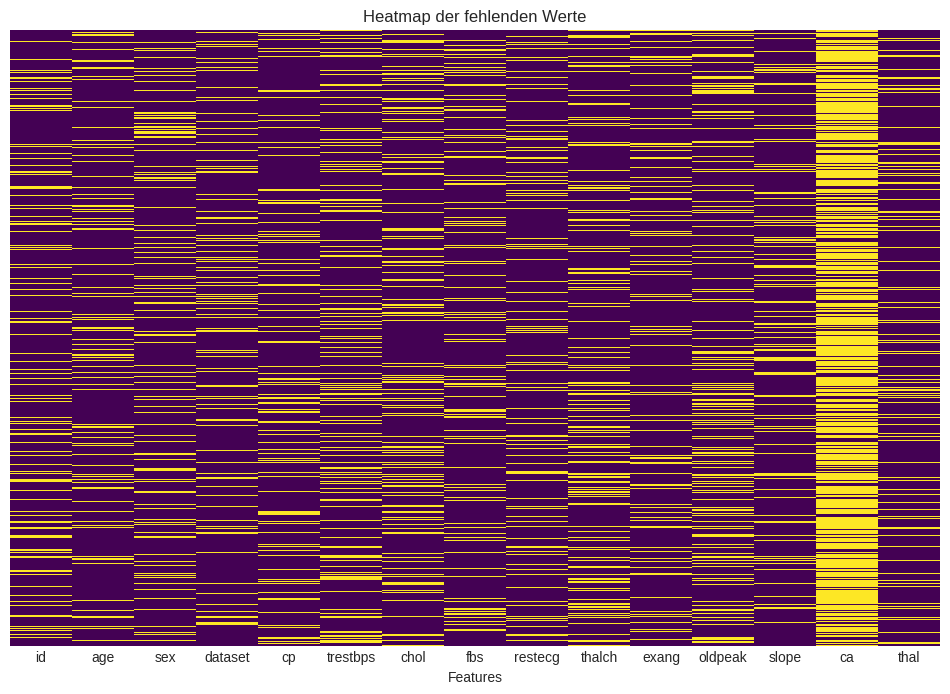

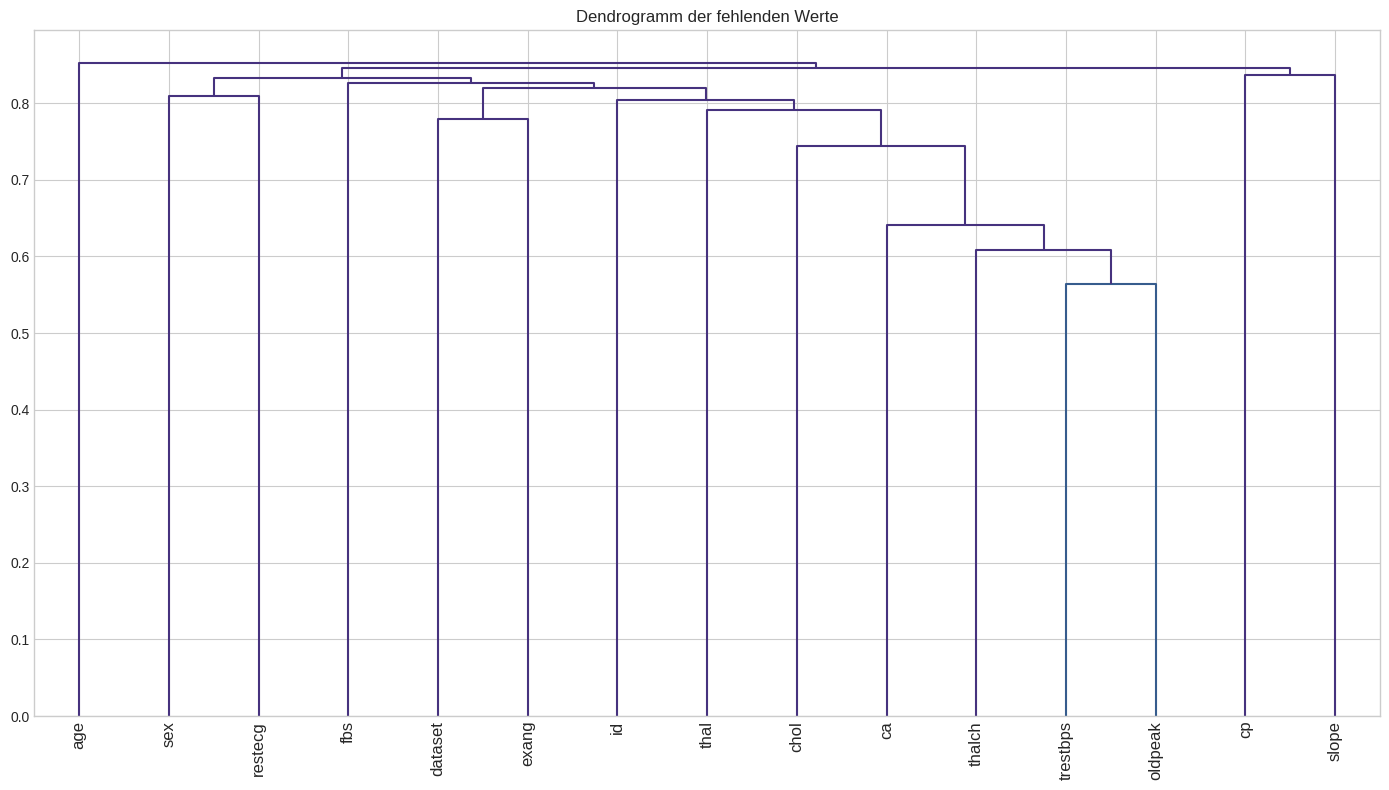

In [262]:
# Heatmap der fehlenden Werte
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Heatmap der fehlenden Werte')
plt.xlabel('Features')
plt.show()

# Dendrogramm für die Clusterung fehlender Werte
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

plt.figure(figsize=(14, 8))
# Distanzmatrix basierend auf fehlenden Werten
mask = X_train.isnull().values
if not np.all(~mask):  # Prüfen, ob es fehlende Werte gibt
	distance_matrix = pdist(mask.T, metric='dice')
	linkage = hierarchy.linkage(distance_matrix, method='average')
	dendro = hierarchy.dendrogram(linkage, labels=X_train.columns, leaf_rotation=90)
	plt.title('Dendrogramm der fehlenden Werte')
	plt.tight_layout()
	plt.show()
else:
	print("Keine fehlenden Werte für das Dendrogramm vorhanden.")

## 3. Methoden zur Behandlung fehlender Werte

## 3.1 Ignorieren fehlender Werte

In [263]:
# XGBoost-Modell mit Originaldaten (fehlende Werte werden intern behandelt)
model_ignore = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)

# Trainieren des Modells
model_ignore.fit(X_train, y_train)

# Vorhersagen
y_pred_ignore = model_ignore.predict(X_test)

# Bewertung
accuracy_ignore = accuracy_score(y_test, y_pred_ignore)
print(f"Genauigkeit (Ignorieren fehlender Werte): {accuracy_ignore:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_ignore))

Genauigkeit (Ignorieren fehlender Werte): 0.8641

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



### 3.2 Löschen fehlender Werte

#### 3.2.1 Paarweise Löschung (Löschen von Zeilen)

In [264]:
# Kopie erstellen und Zeilen mit fehlenden Werten entfernen
X_train_droprows = X_train.dropna()
y_train_droprows = y_train[X_train_droprows.index]

print(f"Originale Trainingsdaten: {X_train.shape[0]} Zeilen")
print(f"Nach Zeilenlöschung: {X_train_droprows.shape[0]} Zeilen")
print(f"Anzahl gelöschter Zeilen: {X_train.shape[0] - X_train_droprows.shape[0]}")

# Training
model_droprows = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_droprows.fit(X_train_droprows, y_train_droprows)

# Für die Vorhersage müssen wir mit den fehlenden Werten im Testset umgehen
# Wir verwenden hier die eingebaute Behandlung von XGBoost
y_pred_droprows = model_droprows.predict(X_test)

# Bewertung
accuracy_droprows = accuracy_score(y_test, y_pred_droprows)
print(f"\nGenauigkeit (Paarweise Löschung): {accuracy_droprows:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_droprows))

Originale Trainingsdaten: 736 Zeilen
Nach Zeilenlöschung: 19 Zeilen
Anzahl gelöschter Zeilen: 717

Genauigkeit (Paarweise Löschung): 0.6304

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.72      0.28      0.40        82
           1       0.61      0.91      0.73       102

    accuracy                           0.63       184
   macro avg       0.67      0.60      0.57       184
weighted avg       0.66      0.63      0.59       184



#### 3.2.2 Löschen ganzer Spalten

In [265]:
# Schwellenwert für den Anteil fehlender Werte, ab dem eine Spalte gelöscht wird
threshold = 0.1  # 10%

# Berechnung der Prozentsätze fehlender Werte
missing_values = X_train.isnull().sum()
missing_percentage = (missing_values / len(X_train)) * 100
missing_info = pd.DataFrame({
	'Fehlende Werte': missing_values,
	'Prozentsatz': missing_percentage
})

print("Übersicht über fehlende Werte:")
print(missing_info.sort_values('Prozentsatz', ascending=False))

# Identifizieren von Spalten mit hohem Anteil fehlender Werte
high_missing_cols = missing_info[missing_info['Prozentsatz'] > threshold * 100].index.tolist()
print(f"\nSpalten mit mehr als {threshold*100}% fehlenden Werten: {high_missing_cols}")

# Sicherheitscheck: Mindestens 3 Spalten behalten
min_features = 3
max_cols_to_remove = X_train.shape[1] - min_features

if len(high_missing_cols) > max_cols_to_remove:
	print(f"Warnung: {len(high_missing_cols)} Spalten würden entfernt, aber mindestens {min_features} werden benötigt.")

	# Spalten nach Prozentsatz der fehlenden Werte sortieren und nur die schlimmsten entfernen
	missing_sorted = missing_info.sort_values('Prozentsatz', ascending=False)
	high_missing_cols = missing_sorted.head(max_cols_to_remove).index.tolist()

	print(f"Entferne stattdessen nur die {len(high_missing_cols)} Spalten mit den meisten fehlenden Werten:")
	for col in high_missing_cols:
		print(f"  - {col}: {missing_info.loc[col, 'Prozentsatz']:.1f}% fehlend")

# Falls immer noch zu viele Spalten entfernt werden, Schwellenwert erhöhen
if len(high_missing_cols) >= X_train.shape[1] - 1:
	print("Warnung: Schwellenwert zu niedrig. Erhöhe Schwellenwert auf 50%.")
	threshold = 0.5
	high_missing_cols = missing_info[missing_info['Prozentsatz'] > threshold * 100].index.tolist()
	print(f"Neue Spalten zum Entfernen: {high_missing_cols}")

# Falls immer noch Probleme, verwende einen anderen Ansatz
if len(high_missing_cols) >= X_train.shape[1] - 1:
	print("Extremfall: Fast alle Spalten haben viele fehlende Werte.")
	print("Verwende die 5 Spalten mit den wenigsten fehlenden Werten.")

	# Die 5 besten Spalten behalten
	best_cols = missing_info.nsmallest(min(5, X_train.shape[1]), 'Prozentsatz').index.tolist()
	cols_to_keep = best_cols
	high_missing_cols = [col for col in X_train.columns if col not in cols_to_keep]

	print(f"Behalte nur diese Spalten: {cols_to_keep}")

# Spalten entfernen
if len(high_missing_cols) > 0:
	X_train_dropcols = X_train.drop(columns=high_missing_cols)
	X_test_dropcols = X_test.drop(columns=high_missing_cols)
else:
	print("Keine Spalten zum Entfernen gefunden.")
	X_train_dropcols = X_train.copy()
	X_test_dropcols = X_test.copy()

print(f"\nErgebnis:")
print(f"Originale Anzahl an Features: {X_train.shape[1]}")
print(f"Nach Spaltenlöschung: {X_train_dropcols.shape[1]}")
print(f"Entfernte Spalten: {len(high_missing_cols)}")

# Überprüfen, ob noch Daten vorhanden sind
if X_train_dropcols.shape[1] == 0:
	print("Fehler: Keine Spalten mehr vorhanden! Verwende Originaldaten.")
	X_train_dropcols = X_train.copy()
	X_test_dropcols = X_test.copy()
	accuracy_dropcols = 0.0
	print("Genauigkeit (Löschen ganzer Spalten): Nicht verfügbar - keine gültigen Daten")
else:
	# Überprüfen auf verbleibende fehlende Werte
	remaining_missing = X_train_dropcols.isnull().sum().sum()
	print(f"Verbleibende fehlende Werte: {remaining_missing}")

	if remaining_missing > 0:
		print("Warnung: Es gibt noch fehlende Werte. Fülle diese mit dem Median auf.")
		# Einfache Imputation für verbleibende fehlende Werte
		imputer_simple = SimpleImputer(strategy='median')
		X_train_dropcols = pd.DataFrame(
			imputer_simple.fit_transform(X_train_dropcols),
			columns=X_train_dropcols.columns,
			index=X_train_dropcols.index
		)
		X_test_dropcols = pd.DataFrame(
			imputer_simple.transform(X_test_dropcols),
			columns=X_test_dropcols.columns,
			index=X_test_dropcols.index
		)

	try:
		# Training
		model_dropcols = xgb.XGBClassifier(
			objective='binary:logistic',
			random_state=42,
			use_label_encoder=False,
			eval_metric='logloss'
		)
		model_dropcols.fit(X_train_dropcols, y_train)

		# Vorhersage
		y_pred_dropcols = model_dropcols.predict(X_test_dropcols)

		# Bewertung
		accuracy_dropcols = accuracy_score(y_test, y_pred_dropcols)
		print(f"\nGenauigkeit (Löschen ganzer Spalten): {accuracy_dropcols:.4f}")
		print("\nKlassifikationsbericht:")
		print(classification_report(y_test, y_pred_dropcols))

	except Exception as e:
		print(f"Fehler beim Training: {e}")
		print("Setze Genauigkeit auf 0.0")
		accuracy_dropcols = 0.0

Übersicht über fehlende Werte:
          Fehlende Werte  Prozentsatz
ca                   524    71.195652
oldpeak              156    21.195652
trestbps             151    20.516304
thalch               151    20.516304
chol                 138    18.750000
id                   119    16.168478
sex                  117    15.896739
cp                   112    15.217391
fbs                  112    15.217391
exang                109    14.809783
dataset              108    14.673913
slope                108    14.673913
thal                 106    14.402174
restecg              104    14.130435
age                  100    13.586957

Spalten mit mehr als 10.0% fehlenden Werten: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Warnung: 15 Spalten würden entfernt, aber mindestens 3 werden benötigt.
Entferne stattdessen nur die 12 Spalten mit den meisten fehlenden Werten:
  - ca: 71.2% fehlend
  - oldpeak: 21.2%

### 3.3 Statistische Imputation

#### 3.3.1 Mittelwert-Imputation

In [266]:
# Imputation mit Mittelwert
imputer_mean = SimpleImputer(strategy='mean')
X_train_mean = pd.DataFrame(imputer_mean.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_mean = pd.DataFrame(imputer_mean.transform(X_test), columns=X_test.columns, index=X_test.index)

# Training
model_mean = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_mean.fit(X_train_mean, y_train)

# Vorhersage
y_pred_mean = model_mean.predict(X_test_mean)

# Bewertung
accuracy_mean = accuracy_score(y_test, y_pred_mean)
print(f"Genauigkeit (Mittelwert-Imputation): {accuracy_mean:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_mean))

Genauigkeit (Mittelwert-Imputation): 0.8424

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        82
           1       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



#### 3.3.2 Median-Imputation

In [267]:
# Imputation mit Median
imputer_median = SimpleImputer(strategy='median')
X_train_median = pd.DataFrame(imputer_median.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_median = pd.DataFrame(imputer_median.transform(X_test), columns=X_test.columns, index=X_test.index)

# Training
model_median = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_median.fit(X_train_median, y_train)

# Vorhersage
y_pred_median = model_median.predict(X_test_median)

# Bewertung
accuracy_median = accuracy_score(y_test, y_pred_median)
print(f"Genauigkeit (Median-Imputation): {accuracy_median:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_median))

Genauigkeit (Median-Imputation): 0.8478

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        82
           1       0.84      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



#### 3.3.3 Konstante Werte

In [268]:
# Imputation mit konstanten Werten (hier: 0)
imputer_const = SimpleImputer(strategy='constant', fill_value=0)
X_train_const = pd.DataFrame(imputer_const.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_const = pd.DataFrame(imputer_const.transform(X_test), columns=X_test.columns, index=X_test.index)

# Training
model_const = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_const.fit(X_train_const, y_train)

# Vorhersage
y_pred_const = model_const.predict(X_test_const)

# Bewertung
accuracy_const = accuracy_score(y_test, y_pred_const)
print(f"Genauigkeit (Konstante Imputation mit 0): {accuracy_const:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_const))

Genauigkeit (Konstante Imputation mit 0): 0.8424

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.84      0.79      0.82        82
           1       0.84      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



### 3.4 Weitere Imputationsmethoden

#### 3.4.1 Vorwärtsfüllung (Forward Fill)

In [269]:
# Kopien erstellen
X_train_ffill = X_train.copy()
X_test_ffill = X_test.copy()

# Forward Fill anwenden (erfordert eine sinnvolle Reihenfolge der Daten)
# Wir sortieren nach 'age' für dieses Beispiel
X_train_sorted = X_train.sort_values(by='age')
X_train_ffill = X_train_sorted.fillna(method='ffill')
# Für Werte am Anfang, die nicht nach vorne gefüllt werden können, verwenden wir Rückwärtsfüllung
X_train_ffill = X_train_ffill.fillna(method='bfill')

# Für den Testdatensatz verwenden wir die gleiche Methode
X_test_sorted = X_test.sort_values(by='age')
X_test_ffill = X_test_sorted.fillna(method='ffill')
X_test_ffill = X_test_ffill.fillna(method='bfill')

# Zurücksortieren in die Originalreihenfolge
X_train_ffill = X_train_ffill.loc[X_train.index]
X_test_ffill = X_test_ffill.loc[X_test.index]

# Training
model_ffill = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_ffill.fit(X_train_ffill, y_train)

# Vorhersage
y_pred_ffill = model_ffill.predict(X_test_ffill)

# Bewertung
accuracy_ffill = accuracy_score(y_test, y_pred_ffill)
print(f"Genauigkeit (Vorwärtsfüllung): {accuracy_ffill:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_ffill))

Genauigkeit (Vorwärtsfüllung): 0.7880

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76        82
           1       0.81      0.80      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184



#### 3.4.2 Rückwärtsfüllung (Backward Fill)

In [270]:
# Kopien erstellen
X_train_bfill = X_train.copy()
X_test_bfill = X_test.copy()

# Backward Fill anwenden (erfordert eine sinnvolle Reihenfolge der Daten)
# Wir sortieren nach 'age' für dieses Beispiel
X_train_sorted = X_train.sort_values(by='age')
X_train_bfill = X_train_sorted.fillna(method='bfill')
# Für Werte am Ende, die nicht nach hinten gefüllt werden können, verwenden wir Vorwärtsfüllung
X_train_bfill = X_train_bfill.fillna(method='ffill')

# Für den Testdatensatz verwenden wir die gleiche Methode
X_test_sorted = X_test.sort_values(by='age')
X_test_bfill = X_test_sorted.fillna(method='bfill')
X_test_bfill = X_test_bfill.fillna(method='ffill')

# Zurücksortieren in die Originalreihenfolge
X_train_bfill = X_train_bfill.loc[X_train.index]
X_test_bfill = X_test_bfill.loc[X_test.index]

# Training
model_bfill = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_bfill.fit(X_train_bfill, y_train)

# Vorhersage
y_pred_bfill = model_bfill.predict(X_test_bfill)

# Bewertung
accuracy_bfill = accuracy_score(y_test, y_pred_bfill)
print(f"Genauigkeit (Rückwärtsfüllung): {accuracy_bfill:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_bfill))

Genauigkeit (Rückwärtsfüllung): 0.8478

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        82
           1       0.84      0.89      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



#### 3.4.3 Lineare Interpolation

In [271]:
# Kopien erstellen
X_train_interp = X_train.copy()
X_test_interp = X_test.copy()

# Lineare Interpolation anwenden (erfordert eine sinnvolle Reihenfolge der Daten)
# Wir sortieren nach 'age' für dieses Beispiel
X_train_sorted = X_train.sort_values(by='age')
X_train_interp = X_train_sorted.interpolate(method='linear')
# Für Werte am Anfang/Ende, die nicht interpoliert werden können
X_train_interp = X_train_interp.fillna(method='ffill').fillna(method='bfill')

# Für den Testdatensatz verwenden wir die gleiche Methode
X_test_sorted = X_test.sort_values(by='age')
X_test_interp = X_test_sorted.interpolate(method='linear')
X_test_interp = X_test_interp.fillna(method='ffill').fillna(method='bfill')

# Zurücksortieren in die Originalreihenfolge
X_train_interp = X_train_interp.loc[X_train.index]
X_test_interp = X_test_interp.loc[X_test.index]

# Training
model_interp = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_interp.fit(X_train_interp, y_train)

# Vorhersage
y_pred_interp = model_interp.predict(X_test_interp)

# Bewertung
accuracy_interp = accuracy_score(y_test, y_pred_interp)
print(f"Genauigkeit (Lineare Interpolation): {accuracy_interp:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_interp))

Genauigkeit (Lineare Interpolation): 0.8478

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        82
           1       0.86      0.87      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



### 3.5 Fortgeschrittene Imputationstechniken

#### 3.5.1 Lineare Regression

In [272]:
# Iterative Imputation mit linearer Regression
imputer_regr = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state=42)
X_train_regr = pd.DataFrame(imputer_regr.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_regr = pd.DataFrame(imputer_regr.transform(X_test), columns=X_test.columns, index=X_test.index)

# Training
model_regr = xgb.XGBClassifier(
	objective='binary:logistic',
	random_state=42,
	use_label_encoder=False,
	eval_metric='logloss'
)
model_regr.fit(X_train_regr, y_train)

# Vorhersage
y_pred_regr = model_regr.predict(X_test_regr)

# Bewertung
accuracy_regr = accuracy_score(y_test, y_pred_regr)
print(f"Genauigkeit (Lineare Regression): {accuracy_regr:.4f}")
print("\nKlassifikationsbericht:")
print(classification_report(y_test, y_pred_regr))

Genauigkeit (Lineare Regression): 0.8043

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        82
           1       0.82      0.83      0.83       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



## 5. Vergleich und Diskussion der Ergebnisse

### 5.1 Vergleich der Genauigkeiten


Vergleich der Genauigkeiten verschiedener Methoden:
                      Methode  Genauigkeit
0  Ignorieren fehlender Werte     0.864130
4           Median-Imputation     0.847826
8       Lineare Interpolation     0.847826
7            Rückwärtsfüllung     0.847826
5    Konstante Imputation (0)     0.842391
3       Mittelwert-Imputation     0.842391
9          Lineare Regression     0.804348
6             Vorwärtsfüllung     0.788043
2      Löschen ganzer Spalten     0.652174
1          Paarweise Löschung     0.630435


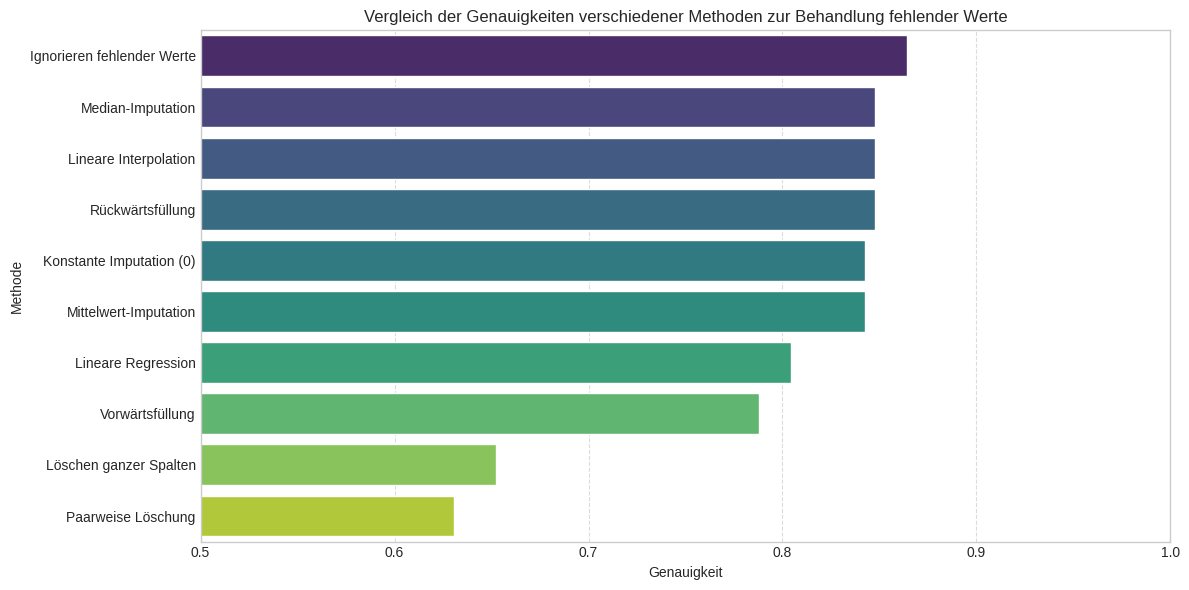

In [273]:
# Ergebnisse sammeln
results = {
	'Ignorieren fehlender Werte': accuracy_ignore,
	'Paarweise Löschung': accuracy_droprows,
	'Löschen ganzer Spalten': accuracy_dropcols,
	'Mittelwert-Imputation': accuracy_mean,
	'Median-Imputation': accuracy_median,
	'Konstante Imputation (0)': accuracy_const,
	'Vorwärtsfüllung': accuracy_ffill,
	'Rückwärtsfüllung': accuracy_bfill,
	'Lineare Interpolation': accuracy_interp,
	'Lineare Regression': accuracy_regr
}

# Ergebnisse sortieren und in DataFrame umwandeln
results_df = pd.DataFrame(
	{'Methode': list(results.keys()), 'Genauigkeit': list(results.values())}
).sort_values('Genauigkeit', ascending=False)

# Tabelle anzeigen
print("Vergleich der Genauigkeiten verschiedener Methoden:")
print(results_df)

# Visualisierung
plt.figure(figsize=(12, 6))
sns.barplot(x='Genauigkeit', y='Methode', data=results_df, palette='viridis')
plt.title('Vergleich der Genauigkeiten verschiedener Methoden zur Behandlung fehlender Werte')
plt.xlabel('Genauigkeit')
plt.ylabel('Methode')
plt.xlim(0.5, 1.0)  # Anpassen des Bereichs
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Ignorieren fehlender Werte:
  Training: 1.0000
  Test: 0.8641
  Differenz: 0.1359

Paarweise Löschung:
  Training: 1.0000
  Test: 0.6304
  Differenz: 0.3696

Löschen ganzer Spalten:
  Training: 0.7541
  Test: 0.6522
  Differenz: 0.1019

Mittelwert-Imputation:
  Training: 1.0000
  Test: 0.8424
  Differenz: 0.1576

Median-Imputation:
  Training: 1.0000
  Test: 0.8478
  Differenz: 0.1522

Konstante Imputation (0):
  Training: 1.0000
  Test: 0.8424
  Differenz: 0.1576

Vorwärtsfüllung:
  Training: 1.0000
  Test: 0.7880
  Differenz: 0.2120

Rückwärtsfüllung:
  Training: 1.0000
  Test: 0.8478
  Differenz: 0.1522

Lineare Interpolation:
  Training: 1.0000
  Test: 0.8478
  Differenz: 0.1522

Lineare Regression:
  Training: 1.0000
  Test: 0.8043
  Differenz: 0.1957

Zusammenfassung - Training vs. Test Genauigkeiten:
                      Methode  Training    Test  Differenz  Overfitting
0  Ignorieren fehlender Werte    1.0000  0.8641     0.1359         True
4           Median-Imputation    1.00

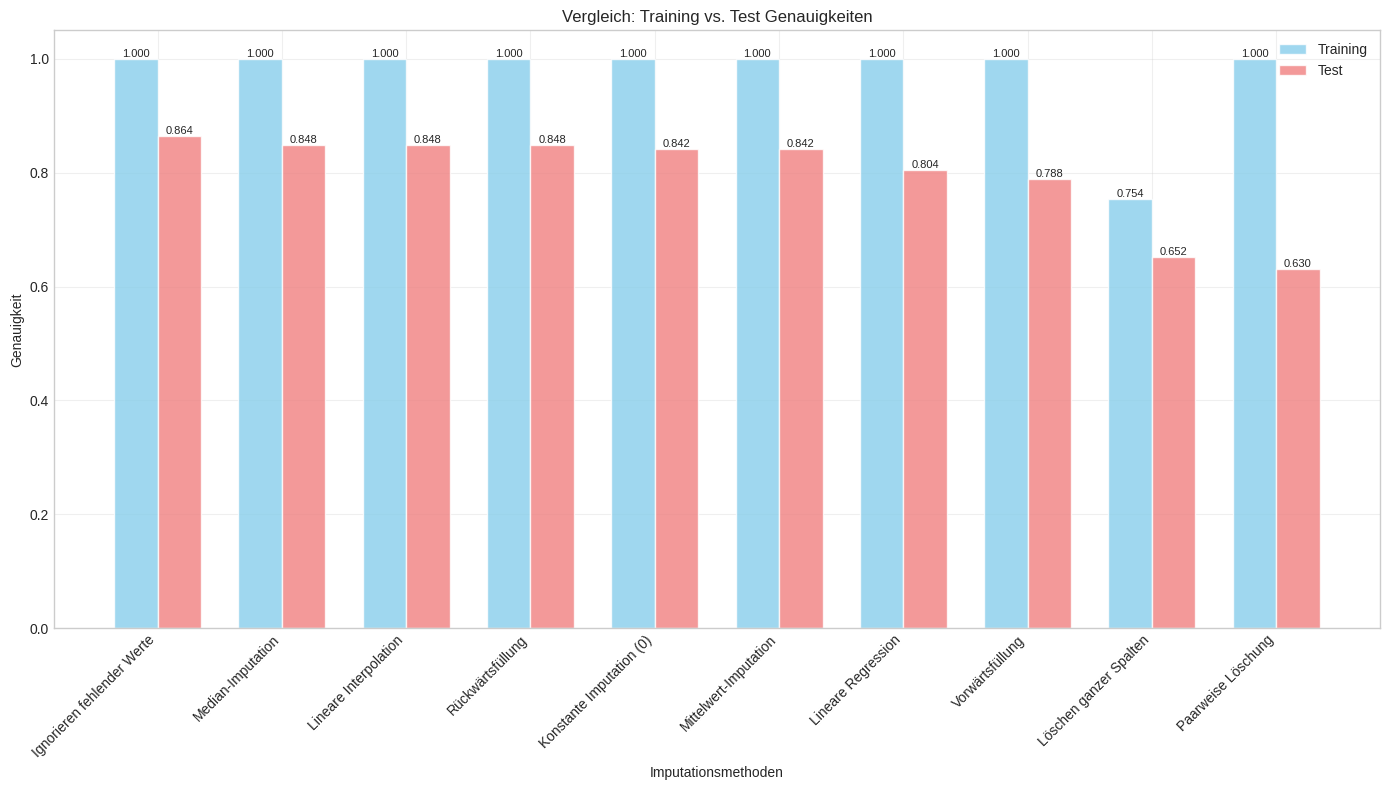

In [274]:
train_accuracies = {}
test_accuracies = {}

# Alle trainierten Modelle und deren Daten
models_and_data = {
	'Ignorieren fehlender Werte': (model_ignore, X_train, X_test),
	'Paarweise Löschung': (model_droprows, X_train_droprows, X_test),
	'Löschen ganzer Spalten': (model_dropcols, X_train_dropcols, X_test_dropcols),
	'Mittelwert-Imputation': (model_mean, X_train_mean, X_test_mean),
	'Median-Imputation': (model_median, X_train_median, X_test_median),
	'Konstante Imputation (0)': (model_const, X_train_const, X_test_const),
	'Vorwärtsfüllung': (model_ffill, X_train_ffill, X_test_ffill),
	'Rückwärtsfüllung': (model_bfill, X_train_bfill, X_test_bfill),
	'Lineare Interpolation': (model_interp, X_train_interp, X_test_interp),
	'Lineare Regression': (model_regr, X_train_regr, X_test_regr)
}

# Berechne Genauigkeiten für alle Methoden
for method_name, (model, X_train_method, X_test_method) in models_and_data.items():
	try:
		# Training-Genauigkeit
		if method_name == 'Paarweise Löschung':
			# Für paarweise Löschung verwenden wir die reduzierten Trainingsdaten
			y_train_pred = model.predict(X_train_method)
			train_acc = accuracy_score(y_train[X_train_method.index], y_train_pred)
		else:
			y_train_pred = model.predict(X_train_method)
			train_acc = accuracy_score(y_train, y_train_pred)

		# Test-Genauigkeit
		y_test_pred = model.predict(X_test_method)
		test_acc = accuracy_score(y_test, y_test_pred)

		train_accuracies[method_name] = train_acc
		test_accuracies[method_name] = test_acc

		print(f"{method_name}:")
		print(f"  Training: {train_acc:.4f}")
		print(f"  Test: {test_acc:.4f}")
		print(f"  Differenz: {train_acc - test_acc:.4f}")
		print()

	except Exception as e:
		print(f"Fehler bei {method_name}: {e}")
		train_accuracies[method_name] = 0.0
		test_accuracies[method_name] = 0.0

# Erstelle DataFrame für bessere Handhabung
comparison_df = pd.DataFrame({
	'Methode': list(train_accuracies.keys()),
	'Training': list(train_accuracies.values()),
	'Test': list(test_accuracies.values())
})

# Berechne Differenz (Overfitting-Indikator)
comparison_df['Differenz'] = comparison_df['Training'] - comparison_df['Test']
comparison_df['Overfitting'] = comparison_df['Differenz'] > 0.05  # Schwellenwert für Overfitting

# Sortiere nach Test-Genauigkeit
comparison_df = comparison_df.sort_values('Test', ascending=False)

print("Zusammenfassung - Training vs. Test Genauigkeiten:")
print("="*60)
print(comparison_df.round(4))

# Visualisierung 1: Balkendiagramm nebeneinander
plt.figure(figsize=(14, 8))

x = np.arange(len(comparison_df))
width = 0.35

plt.bar(x - width/2, comparison_df['Training'], width, label='Training',
		color='skyblue', alpha=0.8)
plt.bar(x + width/2, comparison_df['Test'], width, label='Test',
		color='lightcoral', alpha=0.8)

plt.xlabel('Imputationsmethoden')
plt.ylabel('Genauigkeit')
plt.title('Vergleich: Training vs. Test Genauigkeiten')
plt.xticks(x, comparison_df['Methode'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Annotationen für die Werte
for i, (train_val, test_val) in enumerate(zip(comparison_df['Training'], comparison_df['Test'])):
	plt.annotate(f'{train_val:.3f}', xy=(i - width/2, train_val),
				 ha='center', va='bottom', fontsize=8)
	plt.annotate(f'{test_val:.3f}', xy=(i + width/2, test_val),
				 ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()